In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as ctx
from shapely.wkt import loads
from shapely.geometry import shape, Point
import urllib.request, json
import requests
import urllib.parse
import os

import warnings
warnings.filterwarnings('ignore')

### Script Objectives:

This script filters our two main camera datasets (Amnesty Internation and Hikvision) via spatial joins on Brooklyn's shapefile. This will return a subset of the original camera datasets that we are interested in for our surviellance metric to be created for the neighborhoods across Brooklyn.

#### Input Files:

 **Cameras**

 * Amnesty International Cameras in Brookyln: `../Data/amnesty_international_cameras_brooklyn.csv`

 * Hikvision Cameras in Brooklyn: `../Data/hikvision_camera_brooklyn.csv`
 
  * Aggregated Camera Counts for NYC Census Tracts: `../Data/NYC_tracts_camera_aggregates.csv`


 **Shapefiles**

 * NYC Building Footprint: https://data.cityofnewyork.us/resource/7w4b-tj9d.json

#### Output Files:

In [2]:
#read camera datasets
am_int = gpd.read_file('../Data/amnesty/amnesty_international_cameras_brooklyn.shp', index_col = 0)
hik = gpd.read_file('../Data/hikvision/hikvision_camera_brooklyn.shp', index_col = 0)

In [3]:
am_int.head()

,PanoramaId,n_cameras_,attached_s,attached_b,attached_u,type_dome_,type_bulle,type_unkno,n_camera_1,attached_1,...,type_dom_1,type_bul_1,type_unk_1,Lat,Long,geometry_p,BoroName,URL,ImageDate,geometry
0,--kQB7vdISN5ZhBDo82BHg,0,0,0,0,0,0,0,2 vs 1,Unanimous,...,Unanimous,Unanimous,Unanimous,40.706633,-73.935702,POINT (-73.93570246701009 40.70663303266096),Brooklyn,https://www.google.com/maps/@?api=1&map_action...,2020-11,POINT (-73.93570 40.70663)
1,-0Kgxt4Lfda78gY2WuEMqA,0,0,0,0,0,0,0,2 vs 1,2 vs 1,...,Unanimous,Unanimous,2 vs 1,40.639826,-73.897770,POINT (-73.89777023441276 40.63982610941098),Brooklyn,https://www.google.com/maps/@?api=1&map_action...,2018-06,POINT (-73.89777 40.63983)
2,-0KlvkzMEDcLyTePpuY3sg,5,0,5,0,0,0,0,All disagree,Unanimous,...,Unanimous,Unanimous,Unanimous,40.692888,-73.956733,POINT (-73.95673315914595 40.69288765636261),Brooklyn,https://www.google.com/maps/@?api=1&map_action...,2020-11,POINT (-73.95673 40.69289)
3,-0Y6fGJQcnKZ-crSKaVIfQ,0,0,0,0,0,0,0,2 vs 1,Unanimous,...,Unanimous,Unanimous,Unanimous,40.662758,-73.885122,POINT (-73.88512163867377 40.66275783316144),Brooklyn,https://www.google.com/maps/@?api=1&map_action...,2018-06,POINT (-73.88512 40.66276)
4,-0yXEvW841dBjrs54VZKIA,0,0,0,0,0,0,0,2 vs 1,Unanimous,...,Unanimous,Unanimous,Unanimous,40.655396,-74.003186,POINT (-74.00318577678686 40.65539642907692),Brooklyn,https://www.google.com/maps/@?api=1&map_action...,2019-06,POINT (-74.00319 40.65540)


In [4]:
am_int.columns

Index(['PanoramaId', 'n_cameras_', 'attached_s', 'attached_b', 'attached_u',
       'type_dome_', 'type_bulle', 'type_unkno', 'n_camera_1', 'attached_1',
       'attached_2', 'attached_3', 'type_dom_1', 'type_bul_1', 'type_unk_1',
       'Lat', 'Long', 'geometry_p', 'BoroName', 'URL', 'ImageDate',
       'geometry'],
      dtype='object')

In [5]:
print(len(am_int))
am_int = am_int[am_int['n_cameras_']> 0]
print(len(am_int))

10377
4662


<AxesSubplot:>

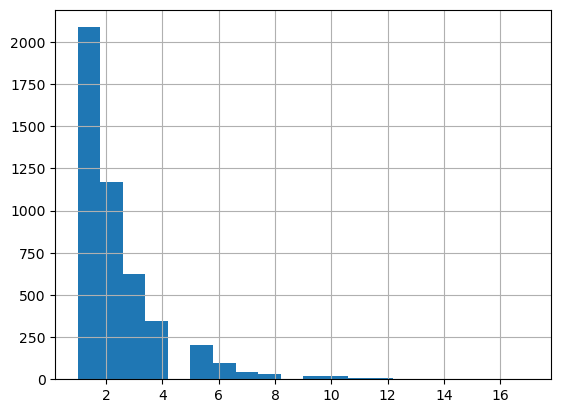

In [6]:
am_int['n_cameras_'].hist(bins = 20)

In [7]:
Coverage = []

for i in range(0,len(am_int)):
    if am_int.iloc[i]['n_cameras_'] == 1:
        Coverage.append('Single Camera')
    else:
        Coverage.append('Multiple Cameras')
am_int['Coverage'] = Coverage
am_int.head()

,PanoramaId,n_cameras_,attached_s,attached_b,attached_u,type_dome_,type_bulle,type_unkno,n_camera_1,attached_1,...,type_bul_1,type_unk_1,Lat,Long,geometry_p,BoroName,URL,ImageDate,geometry,Coverage
2,-0KlvkzMEDcLyTePpuY3sg,5,0,5,0,0,0,0,All disagree,Unanimous,...,Unanimous,Unanimous,40.692888,-73.956733,POINT (-73.95673315914595 40.69288765636261),Brooklyn,https://www.google.com/maps/@?api=1&map_action...,2020-11,POINT (-73.95673 40.69289),Multiple Cameras
7,-3_J1noE14rnXJQAOutg0g,5,0,5,0,0,0,0,All disagree,Unanimous,...,Unanimous,Unanimous,40.629372,-73.972852,POINT (-73.972852 40.629372),Brooklyn,https://www.google.com/maps/@?api=1&map_action...,2020-11,POINT (-73.97285 40.62937),Multiple Cameras
10,-4FkkIbALjSxxgzxg-ssNg,1,0,0,0,0,0,0,All disagree,Unanimous,...,Unanimous,Unanimous,40.706149,-73.965655,POINT (-73.9656547 40.7061494),Brooklyn,https://www.google.com/maps/@?api=1&map_action...,2020-11,POINT (-73.96565 40.70615),Single Camera
11,-4VW6uRzAgbhI_gYKrTxDQ,7,0,7,0,0,0,0,2 vs 1,Unanimous,...,Unanimous,Unanimous,40.672012,-73.903590,POINT (-73.90359040904946 40.67201210342986),Brooklyn,https://www.google.com/maps/@?api=1&map_action...,2019-07,POINT (-73.90359 40.67201),Multiple Cameras
15,-694MYTbjy9EXcMHPlP6lw,1,0,1,0,0,0,0,All disagree,Unanimous,...,Unanimous,Unanimous,40.675751,-73.959759,POINT (-73.95975884133387 40.67575133866482),Brooklyn,https://www.google.com/maps/@?api=1&map_action...,2020-11,POINT (-73.95976 40.67575),Single Camera


In [8]:
hik.head()

,Name,Latitude,Longitude,Zip_Code,Borough,geometry_l,wkt,geometry
0,100.12.110.237,40.694599,-73.990639,11201.0,Brooklyn,Hikvision: Brooklyn (Layer 1 of 3),POINT Z (-73.99063873 40.69459915 0),POINT (-73.99064 40.69460)
1,100.2.171.33,40.694599,-73.990639,11201.0,Brooklyn,Hikvision: Brooklyn (Layer 1 of 3),POINT Z (-73.99063873 40.69459915 0),POINT (-73.99064 40.69460)
2,100.2.223.120,40.694599,-73.990639,11201.0,Brooklyn,Hikvision: Brooklyn (Layer 1 of 3),POINT Z (-73.99063873 40.69459915 0),POINT (-73.99064 40.69460)
3,100.2.223.225,40.694599,-73.990639,11201.0,Brooklyn,Hikvision: Brooklyn (Layer 1 of 3),POINT Z (-73.99063873 40.69459915 0),POINT (-73.99064 40.69460)
4,100.33.242.212,40.702461,-73.987801,11201.0,Brooklyn,Hikvision: Brooklyn (Layer 1 of 3),POINT Z (-73.9878006 40.70246124 0),POINT (-73.98780 40.70246)


In [9]:
## create buffer zone around camera point locations
#add 120m around each shape
am_int = am_int.to_crs('EPSG:32118') # Use an appropriate projected system for your area
am_int['buffer_distance'] = 120 # in meters
buffered_gdf = pd.DataFrame()

for index, row in am_int.iterrows():
    polygon = row.geometry
    buffer_distance = row.buffer_distance
    buffered_polygon = polygon.buffer(buffer_distance, cap_style=1)
    buffered_gdf = buffered_gdf.append({'geometry': buffered_polygon}, ignore_index=True)
    
am_int_buff = gpd.GeoDataFrame(buffered_gdf,crs = am_int.crs)
am_int_buff = am_int_buff.to_crs('EPSG:4326') # Use an appropriate projected system for your area

In [10]:
am_int_buff_120 = pd.merge(am_int.drop(columns=['geometry']),am_int_buff, left_index=True, right_index=True)
am_int_buff_120 = gpd.GeoDataFrame(am_int_buff_120,geometry = 'geometry', crs = 'EPSG:4326')
am_int_buff_120.head()

,PanoramaId,n_cameras_,attached_s,attached_b,attached_u,type_dome_,type_bulle,type_unkno,n_camera_1,attached_1,...,type_unk_1,Lat,Long,geometry_p,BoroName,URL,ImageDate,Coverage,buffer_distance,geometry
2,-0KlvkzMEDcLyTePpuY3sg,5,0,5,0,0,0,0,All disagree,Unanimous,...,Unanimous,40.692888,-73.956733,POINT (-73.95673315914595 40.69288765636261),Brooklyn,https://www.google.com/maps/@?api=1&map_action...,2020-11,Multiple Cameras,120,"POLYGON ((-73.96423 40.70615, -73.96424 40.706..."
7,-3_J1noE14rnXJQAOutg0g,5,0,5,0,0,0,0,All disagree,Unanimous,...,Unanimous,40.629372,-73.972852,POINT (-73.972852 40.629372),Brooklyn,https://www.google.com/maps/@?api=1&map_action...,2020-11,Multiple Cameras,120,"POLYGON ((-73.93833 40.57824, -73.93834 40.578..."
10,-4FkkIbALjSxxgzxg-ssNg,1,0,0,0,0,0,0,All disagree,Unanimous,...,Unanimous,40.706149,-73.965655,POINT (-73.9656547 40.7061494),Brooklyn,https://www.google.com/maps/@?api=1&map_action...,2020-11,Single Camera,120,"POLYGON ((-73.94401 40.65900, -73.94402 40.658..."
11,-4VW6uRzAgbhI_gYKrTxDQ,7,0,7,0,0,0,0,2 vs 1,Unanimous,...,Unanimous,40.672012,-73.903590,POINT (-73.90359040904946 40.67201210342986),Brooklyn,https://www.google.com/maps/@?api=1&map_action...,2019-07,Multiple Cameras,120,"POLYGON ((-73.92101 40.59024, -73.92102 40.590..."
15,-694MYTbjy9EXcMHPlP6lw,1,0,1,0,0,0,0,All disagree,Unanimous,...,Unanimous,40.675751,-73.959759,POINT (-73.95975884133387 40.67575133866482),Brooklyn,https://www.google.com/maps/@?api=1&map_action...,2020-11,Single Camera,120,"POLYGON ((-73.92927 40.69151, -73.92927 40.691..."


In [11]:
## create buffer zone around camera point locations
#add 200m around each shape
am_int = am_int.to_crs('EPSG:32118') # Use an appropriate projected system for your area
am_int['buffer_distance'] = 200 # in meters
buffered_gdf = pd.DataFrame()

for index, row in am_int.iterrows():
    polygon = row.geometry
    buffer_distance = row.buffer_distance
    buffered_polygon = polygon.buffer(buffer_distance, cap_style=1)
    buffered_gdf = buffered_gdf.append({'geometry': buffered_polygon}, ignore_index=True)
    
am_int_buff = gpd.GeoDataFrame(buffered_gdf,crs = am_int.crs)
am_int_buff = am_int_buff.to_crs('EPSG:4326') # Use an appropriate projected system for your area

In [12]:
am_int_buff_200 = pd.merge(am_int.drop(columns=['geometry']),am_int_buff, left_index=True, right_index=True)
am_int_buff_200 = gpd.GeoDataFrame(am_int_buff_200,geometry = 'geometry', crs = 'EPSG:4326')
am_int_buff_200.head()

,PanoramaId,n_cameras_,attached_s,attached_b,attached_u,type_dome_,type_bulle,type_unkno,n_camera_1,attached_1,...,type_unk_1,Lat,Long,geometry_p,BoroName,URL,ImageDate,Coverage,buffer_distance,geometry
2,-0KlvkzMEDcLyTePpuY3sg,5,0,5,0,0,0,0,All disagree,Unanimous,...,Unanimous,40.692888,-73.956733,POINT (-73.95673315914595 40.69288765636261),Brooklyn,https://www.google.com/maps/@?api=1&map_action...,2020-11,Multiple Cameras,200,"POLYGON ((-73.96329 40.70615, -73.96330 40.705..."
7,-3_J1noE14rnXJQAOutg0g,5,0,5,0,0,0,0,All disagree,Unanimous,...,Unanimous,40.629372,-73.972852,POINT (-73.972852 40.629372),Brooklyn,https://www.google.com/maps/@?api=1&map_action...,2020-11,Multiple Cameras,200,"POLYGON ((-73.93738 40.57824, -73.93740 40.578..."
10,-4FkkIbALjSxxgzxg-ssNg,1,0,0,0,0,0,0,All disagree,Unanimous,...,Unanimous,40.706149,-73.965655,POINT (-73.9656547 40.7061494),Brooklyn,https://www.google.com/maps/@?api=1&map_action...,2020-11,Single Camera,200,"POLYGON ((-73.94306 40.65900, -73.94308 40.658..."
11,-4VW6uRzAgbhI_gYKrTxDQ,7,0,7,0,0,0,0,2 vs 1,Unanimous,...,Unanimous,40.672012,-73.903590,POINT (-73.90359040904946 40.67201210342986),Brooklyn,https://www.google.com/maps/@?api=1&map_action...,2019-07,Multiple Cameras,200,"POLYGON ((-73.92007 40.59024, -73.92008 40.590..."
15,-694MYTbjy9EXcMHPlP6lw,1,0,1,0,0,0,0,All disagree,Unanimous,...,Unanimous,40.675751,-73.959759,POINT (-73.95975884133387 40.67575133866482),Brooklyn,https://www.google.com/maps/@?api=1&map_action...,2020-11,Single Camera,200,"POLYGON ((-73.92832 40.69151, -73.92833 40.691..."


In [13]:
## create buffer zone around camera point locations
#add 200m around each shape
hik = hik.to_crs('EPSG:32118') # Use an appropriate projected system for your area
hik['buffer_distance'] = 200 # in meters
buffered_gdf = pd.DataFrame()

for index, row in hik.iterrows():
    polygon = row.geometry
    buffer_distance = row.buffer_distance
    buffered_polygon = polygon.buffer(buffer_distance, cap_style=1)
    buffered_gdf = buffered_gdf.append({'geometry': buffered_polygon}, ignore_index=True)
    
hik_buff = gpd.GeoDataFrame(buffered_gdf,crs = hik.crs)
hik_buff = hik_buff.to_crs('EPSG:4326') # Use an appropriate projected system for your area

In [14]:
hik_buff_200 = pd.merge(hik.drop(columns=['geometry']),hik_buff, left_index=True, right_index=True)
hik_buff_200 = gpd.GeoDataFrame(hik_buff_200,geometry = 'geometry', crs = 'EPSG:4326')
hik_buff_200.head()

,Name,Latitude,Longitude,Zip_Code,Borough,geometry_l,wkt,buffer_distance,geometry
0,100.12.110.237,40.694599,-73.990639,11201.0,Brooklyn,Hikvision: Brooklyn (Layer 1 of 3),POINT Z (-73.99063873 40.69459915 0),200,"POLYGON ((-73.98827 40.69460, -73.98828 40.694..."
1,100.2.171.33,40.694599,-73.990639,11201.0,Brooklyn,Hikvision: Brooklyn (Layer 1 of 3),POINT Z (-73.99063873 40.69459915 0),200,"POLYGON ((-73.98827 40.69460, -73.98828 40.694..."
2,100.2.223.120,40.694599,-73.990639,11201.0,Brooklyn,Hikvision: Brooklyn (Layer 1 of 3),POINT Z (-73.99063873 40.69459915 0),200,"POLYGON ((-73.98827 40.69460, -73.98828 40.694..."
3,100.2.223.225,40.694599,-73.990639,11201.0,Brooklyn,Hikvision: Brooklyn (Layer 1 of 3),POINT Z (-73.99063873 40.69459915 0),200,"POLYGON ((-73.98827 40.69460, -73.98828 40.694..."
4,100.33.242.212,40.702461,-73.987801,11201.0,Brooklyn,Hikvision: Brooklyn (Layer 1 of 3),POINT Z (-73.9878006 40.70246124 0),200,"POLYGON ((-73.98543 40.70246, -73.98545 40.702..."


In [15]:
#combine both dataframes into one
# create a new dataframe with the desired columns
combined_camera_gdf = gpd.GeoDataFrame(columns=['Data_Source', 'Camera_Count', 'geometry'],crs = 4326)
am_int_buff_200['Data_Source'] = 'Amnesty'
hik_buff_200['Data_Source'] = 'Hikvision'
hik_buff_200['Camera_Count'] = 1

# add the geometries and camera counts from amn_int_buff_200
combined_camera_gdf = combined_camera_gdf.append(am_int_buff_200[['Data_Source','n_cameras_', 'geometry']].rename(columns={'n_cameras_': 'Camera_Count'}))

# add the geometries and camera counts from hik_buff_200, setting the camera count to 1
combined_camera_gdf = combined_camera_gdf.append(hik_buff_200[['Data_Source','Camera_Count', 'geometry']])

# reset the index of the new geodataframe
combined_camera_gdf = combined_camera_gdf.reset_index(drop=True)
combined_camera_gdf.head()

,Data_Source,Camera_Count,geometry
0,Amnesty,5,"POLYGON ((-73.96329 40.70615, -73.96330 40.705..."
1,Amnesty,5,"POLYGON ((-73.93738 40.57824, -73.93740 40.578..."
2,Amnesty,1,"POLYGON ((-73.94306 40.65900, -73.94308 40.658..."
3,Amnesty,7,"POLYGON ((-73.92007 40.59024, -73.92008 40.590..."
4,Amnesty,1,"POLYGON ((-73.92832 40.69151, -73.92833 40.691..."


In [16]:
combined_camera_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

# Lets look into building footprints dataset to get a more accurate representation of building obstruction to the camera fields of view


## [NYC Building Footprints](https://data.cityofnewyork.us/resource/qb5r-6dgf.json)

The metadata for this dataset can be found [here](https://github.com/CityOfNewYork/nyc-geo-metadata/blob/master/Metadata/Metadata_BuildingFootprints.md).

In [17]:
#use SODA API to get building footprints
url = 'https://data.cityofnewyork.us/resource/qb5r-6dgf.json'

query = (url+'?'
        "$select=*"
        "&$where=starts_with(bin::text, '3')"
        "&$limit=5000000")
query = query.replace(" ", "%20")
print(query)
response = urllib.request.urlopen(query)
data = json.loads(response.read())

for d in data:
    d['geometry'] = shape(d['the_geom'])

#store in a geodataframe
building_gdf = gpd.GeoDataFrame(data, geometry = 'geometry', crs = 'EPSG: 4326')
building_gdf = building_gdf.drop(columns = ['the_geom'])
building_gdf.head()

https://data.cityofnewyork.us/resource/qb5r-6dgf.json?$select=*&$where=starts_with(bin::text,%20'3')&$limit=5000000


,bin,cnstrct_yr,lstmoddate,lststatype,doitt_id,heightroof,feat_code,groundelev,shape_area,shape_len,base_bbl,mpluto_bbl,geomsource,geometry,name
0,3170958,1925,2017-08-22T00:00:00.000,Constructed,96807,29.74985318,2100,40,0.0,0.0,3065220021,3065220021,Photogramm,"MULTIPOLYGON (((-73.96665 40.62600, -73.96685 ...",NaN
1,3245111,1928,2017-08-22T00:00:00.000,Constructed,786626,37.5,2100,6,0.0,0.0,3086910048,3086910048,Photogramm,"MULTIPOLYGON (((-73.96113 40.57744, -73.96115 ...",NaN
2,3088045,1905,2017-08-22T00:00:00.000,Constructed,636591,27.03,2100,37,0.0,0.0,3039550030,3039550030,Photogramm,"MULTIPOLYGON (((-73.88377 40.67953, -73.88387 ...",NaN
3,3401793,1920,2017-08-17T00:00:00.000,Constructed,1204424,15.04,5110,25,0.0,0.0,3062890021,3062890021,Photogramm,"MULTIPOLYGON (((-73.98955 40.60449, -73.98959 ...",NaN
4,3099098,1928,2017-08-22T00:00:00.000,Constructed,111394,67.91,2100,37,0.0,0.0,3045880001,3045880001,Photogramm,"MULTIPOLYGON (((-73.93395 40.66244, -73.93395 ...",NaN


In [18]:
len(building_gdf)

330954

<AxesSubplot:>

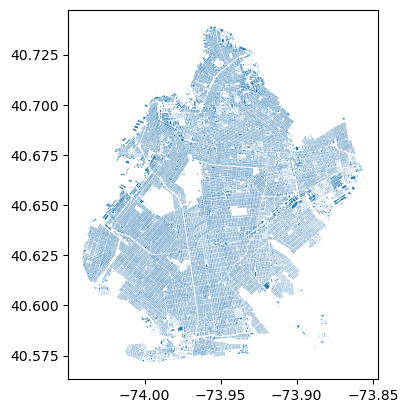

In [19]:
building_gdf.plot()

In [20]:
building_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [21]:
building_gdf = building_gdf.to_crs(32118)
# Compute area in square km
building_gdf['Building Area'] = building_gdf.geometry.area / 10**6
#re-project
building_gdf = building_gdf.to_crs(4326)
building_gdf.head()

,bin,cnstrct_yr,lstmoddate,lststatype,doitt_id,heightroof,feat_code,groundelev,shape_area,shape_len,base_bbl,mpluto_bbl,geomsource,geometry,name,Building Area
0,3170958,1925,2017-08-22T00:00:00.000,Constructed,96807,29.74985318,2100,40,0.0,0.0,3065220021,3065220021,Photogramm,"MULTIPOLYGON (((-73.96665 40.62600, -73.96685 ...",NaN,0.000152
1,3245111,1928,2017-08-22T00:00:00.000,Constructed,786626,37.5,2100,6,0.0,0.0,3086910048,3086910048,Photogramm,"MULTIPOLYGON (((-73.96113 40.57744, -73.96115 ...",NaN,0.000108
2,3088045,1905,2017-08-22T00:00:00.000,Constructed,636591,27.03,2100,37,0.0,0.0,3039550030,3039550030,Photogramm,"MULTIPOLYGON (((-73.88377 40.67953, -73.88387 ...",NaN,0.000106
3,3401793,1920,2017-08-17T00:00:00.000,Constructed,1204424,15.04,5110,25,0.0,0.0,3062890021,3062890021,Photogramm,"MULTIPOLYGON (((-73.98955 40.60449, -73.98959 ...",NaN,0.000031
4,3099098,1928,2017-08-22T00:00:00.000,Constructed,111394,67.91,2100,37,0.0,0.0,3045880001,3045880001,Photogramm,"MULTIPOLYGON (((-73.93395 40.66244, -73.93395 ...",NaN,0.001324


In [22]:
#load boundary file
bk_bndry = gpd.read_file('../Data/BrooklynBoundary.shp')
bk_bndry.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [23]:
#clip to bk boundary extent to remove the camera area outside of boundary
camera_buff_200_clipped = combined_camera_gdf.clip(bk_bndry)

In [24]:
##lets take the difference of the 200m buffer geometry in comparison to the Brooklyn MapPLUTO geometry
# Calculate the difference between the two GeoDataFrames
street_surv_area = gpd.overlay(camera_buff_200_clipped, building_gdf, how='difference')

In [25]:
street_surv_area.head()

,Data_Source,Camera_Count,geometry
0,Amnesty,3,"MULTIPOLYGON (((-73.96168 40.71441, -73.96172 ..."
1,Amnesty,1,"MULTIPOLYGON (((-73.96129 40.71423, -73.96134 ..."
2,Amnesty,2,"MULTIPOLYGON (((-73.95677 40.71550, -73.95670 ..."
3,Hikvision,1,"MULTIPOLYGON (((-73.95949 40.71345, -73.95947 ..."
4,Amnesty,2,"MULTIPOLYGON (((-73.95378 40.71597, -73.95365 ..."


Text(0.5, 1.0, 'Amnesty International Camera Buffer Zones Building Footprint Clip (200m)')

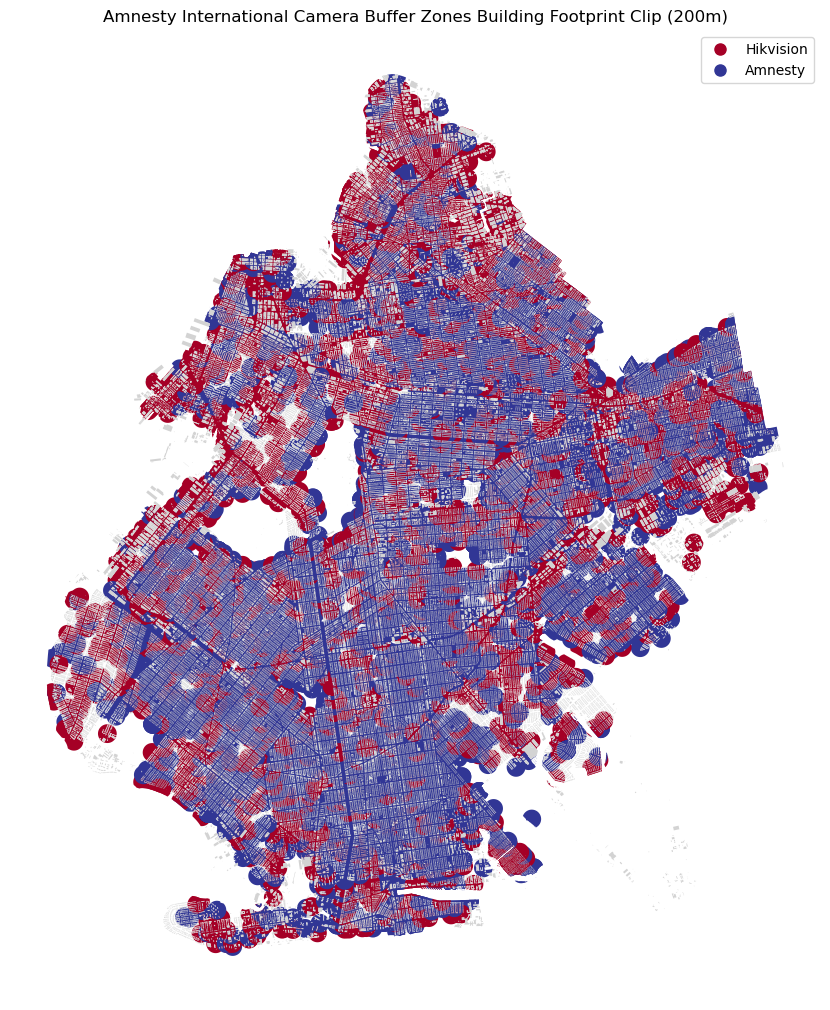

In [26]:
# set up the color scheme and labels
cmap = plt.cm.get_cmap('RdYlBu', 2)
colors = {'A': cmap(0.1), 'B': cmap(0.9)}
labels = {'A': 'Hikvision', 'B': 'Amnesty'}

# plot your GeoDataFrame
fig, ax = plt.subplots(figsize=(10,10))
ax.set_aspect('equal')
street_surv_area.plot(column='Data_Source', cmap=cmap, ax=ax, legend=True, legend_kwds={'loc': 'lower right'})

# set the color for each category
for category, color in colors.items():
    ax.plot([], [], color=color, label=labels[category], linewidth=0, marker='o', markersize=8)

# add the legend to the plot
ax.legend()

# add the basemap using contextily
building_gdf.plot(ax = ax, color = 'lightgrey')
plt.axis('off')
plt.tight_layout()
plt.title('Amnesty International Camera Buffer Zones Building Footprint Clip (200m)')
# plt.savefig('../Outputs/MapPLUTO_Clipped_AmnInternation_BK_CameraBuffer_200m.png')

### Follow up Questions for Team 4/11:

1. How do we want to account for multiple cameras in same intersection/location in our metric calculation?
    * add area for each camera regardless of location overlap?
    
    
2. How can we ensure the cameras within the Hikvision dataset are not the same as any camera in the amnesty international dataset?

In [28]:
#meter projection
street_surv_area = street_surv_area.to_crs(32118)
street_surv_area['area_km2'] = street_surv_area.geometry.area / 1e6
street_surv_area['area_cum'] = street_surv_area['area_km2']*street_surv_area['Camera_Count']
#re-project
street_surv_area = street_surv_area.to_crs(4326)
street_surv_area.head()

,Data_Source,Camera_Count,geometry,area_km2,area_cum
0,Amnesty,3,"MULTIPOLYGON (((-73.96168 40.71441, -73.96172 ...",0.070627,0.211882
1,Amnesty,1,"MULTIPOLYGON (((-73.96129 40.71423, -73.96134 ...",0.070620,0.07062
2,Amnesty,2,"MULTIPOLYGON (((-73.95677 40.71550, -73.95670 ...",0.085067,0.170133
3,Hikvision,1,"MULTIPOLYGON (((-73.95949 40.71345, -73.95947 ...",0.071790,0.07179
4,Amnesty,2,"MULTIPOLYGON (((-73.95378 40.71597, -73.95365 ...",0.085435,0.170871


In [29]:
#aggregate to NTA level for now
bk_ntas = gpd.read_file('../Data/BrooklynNTAs/BrooklynNTAs.shp')

In [30]:
#calculate the entire NTA Area
bk_ntas = bk_ntas.to_crs(32118)
bk_ntas['NTA_area_km2'] = bk_ntas.geometry.area / 1e6
bk_ntas = bk_ntas.to_crs(4326)
bk_ntas.head()

,boro_code,boro_name,county_fip,ntacode,ntaname,shape_area,shape_leng,geometry,NTA_area_km2
0,3.0,Brooklyn,047,BK40,Windsor Terrace,1.404167e+07,19033.672066,"POLYGON ((-73.98017 40.66115, -73.98021 40.661...",1.304529
1,3.0,Brooklyn,047,BK50,Canarsie,8.208968e+07,43703.609666,"MULTIPOLYGON (((-73.88834 40.64671, -73.88835 ...",7.626437
2,3.0,Brooklyn,047,BK68,Fort Greene,1.648282e+07,19825.520859,"POLYGON ((-73.96939 40.69608, -73.96938 40.695...",1.531316
3,3.0,Brooklyn,047,BK79,Ocean Hill,2.008991e+07,22494.581245,"POLYGON ((-73.90321 40.67874, -73.90256 40.678...",1.866427
4,3.0,Brooklyn,047,BK44,Madison,2.737916e+07,26237.257649,"POLYGON ((-73.93754 40.60856, -73.93830 40.608...",2.543625


In [31]:
#get non-building space
# use the difference method to get the non-building areas
non_building_gdf = bk_bndry.difference(building_gdf.unary_union)

# drop any empty geometries
non_building_gdf = non_building_gdf[~non_building_gdf.is_empty]

In [32]:
non_building_gdf.head()

0    MULTIPOLYGON (((-74.00209 40.56959, -74.00220 ...
dtype: geometry

In [33]:
non_building_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [34]:
# create an empty geodataframe to store the individual polygons
non_building_poly_gdf = gpd.GeoDataFrame()

# iterate over each geometry in the multipolygon
for poly in non_building_gdf.geometry:
    
    # check if the geometry is a polygon or a multipolygon
    if poly.geom_type == 'Polygon':
        # if it's a polygon, add it directly to the new geodataframe
        non_building_poly_gdf = non_building_poly_gdf.append(gpd.GeoDataFrame(geometry=[poly]), ignore_index=True)
        
    elif poly.geom_type == 'MultiPolygon':
        # if it's a multipolygon, iterate over each polygon in the multipolygon
        for sub_poly in poly:
            # add each polygon to the new geodataframe
            non_building_poly_gdf = non_building_poly_gdf.append(gpd.GeoDataFrame(geometry=[sub_poly]), ignore_index=True)
            
    non_building_poly_gdf.crs = building_gdf.crs

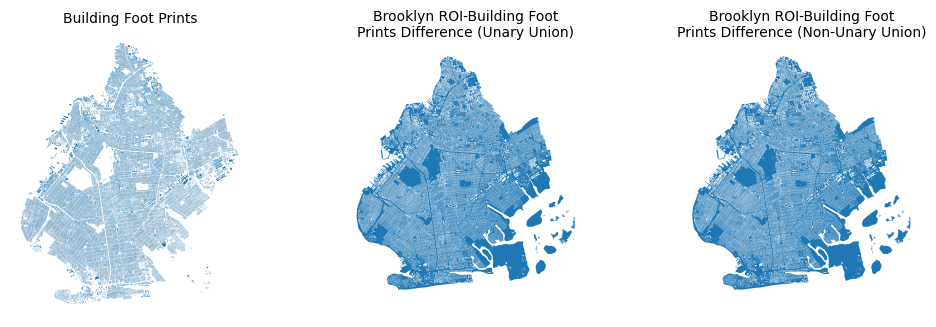

In [36]:
fig, ax = plt.subplots(1,3,figsize = (10,10))
building_gdf.plot(ax = ax[0])
ax[0].set_title('Building Foot Prints',fontsize=10)
non_building_gdf.plot(ax = ax[1])
ax[1].set_title('Brooklyn ROI-Building Foot\nPrints Difference (Unary Union)',fontdict={'fontsize': 10, 'multialignment': 'center'})
# plot the resulting geodataframe
non_building_poly_gdf.plot(ax = ax[2])
ax[2].set_title('Brooklyn ROI-Building Foot\nPrints Difference (Non-Unary Union)',fontdict={'fontsize': 10, 'multialignment': 'center'})
fig.tight_layout()
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
plt.show()

In [37]:
bk_ntas.dtypes

boro_code        float64
boro_name         object
county_fip        object
ntacode           object
ntaname           object
shape_area       float64
shape_leng       float64
geometry        geometry
NTA_area_km2     float64
dtype: object

In [38]:
# # Reproject to a projected coordinate system that uses meters instead of degrees
bk_ntas = bk_ntas.to_crs(4326)

# Spatial join
joined = gpd.sjoin(building_gdf, bk_ntas, how="inner", predicate="within")

In [39]:
joined.head()

,bin,cnstrct_yr,lstmoddate,lststatype,doitt_id,heightroof,feat_code,groundelev,shape_area_left,shape_len,...,Building Area,index_right,boro_code,boro_name,county_fip,ntacode,ntaname,shape_area_right,shape_leng,NTA_area_km2
0,3170958,1925,2017-08-22T00:00:00.000,Constructed,96807,29.74985318,2100,40,0.0,0.0,...,0.000152,30,3.0,Brooklyn,047,BK43,Midwood,3.579958e+07,27996.590624,3.325913
21,3254361,1925,2017-08-22T00:00:00.000,Constructed,418951,35.62,2100,30,0.0,0.0,...,0.000205,30,3.0,Brooklyn,047,BK43,Midwood,3.579958e+07,27996.590624,3.325913
115,3207869,1931,2017-08-22T00:00:00.000,Constructed,839842,31.07164075,2100,27,0.0,0.0,...,0.000160,30,3.0,Brooklyn,047,BK43,Midwood,3.579958e+07,27996.590624,3.325913
164,3181293,1920,2017-08-22T00:00:00.000,Constructed,1016470,36.0,2100,29,0.0,0.0,...,0.000115,30,3.0,Brooklyn,047,BK43,Midwood,3.579958e+07,27996.590624,3.325913
216,3211043,1910,2017-08-22T00:00:00.000,Constructed,472348,39.85,2100,22,0.0,0.0,...,0.000175,30,3.0,Brooklyn,047,BK43,Midwood,3.579958e+07,27996.590624,3.325913


In [40]:
# Compute area in square km
joined['Non-Building area'] = joined.geometry.area / 1e6
excludeval = joined['Non-Building area'].max()
joined = joined[joined['Non-Building area']!=excludeval]
joined.head()

,bin,cnstrct_yr,lstmoddate,lststatype,doitt_id,heightroof,feat_code,groundelev,shape_area_left,shape_len,...,index_right,boro_code,boro_name,county_fip,ntacode,ntaname,shape_area_right,shape_leng,NTA_area_km2,Non-Building area
0,3170958,1925,2017-08-22T00:00:00.000,Constructed,96807,29.74985318,2100,40,0.0,0.0,...,30,3.0,Brooklyn,047,BK43,Midwood,3.579958e+07,27996.590624,3.325913,1.619789e-14
21,3254361,1925,2017-08-22T00:00:00.000,Constructed,418951,35.62,2100,30,0.0,0.0,...,30,3.0,Brooklyn,047,BK43,Midwood,3.579958e+07,27996.590624,3.325913,2.180148e-14
115,3207869,1931,2017-08-22T00:00:00.000,Constructed,839842,31.07164075,2100,27,0.0,0.0,...,30,3.0,Brooklyn,047,BK43,Midwood,3.579958e+07,27996.590624,3.325913,1.699648e-14
164,3181293,1920,2017-08-22T00:00:00.000,Constructed,1016470,36.0,2100,29,0.0,0.0,...,30,3.0,Brooklyn,047,BK43,Midwood,3.579958e+07,27996.590624,3.325913,1.223249e-14
216,3211043,1910,2017-08-22T00:00:00.000,Constructed,472348,39.85,2100,22,0.0,0.0,...,30,3.0,Brooklyn,047,BK43,Midwood,3.579958e+07,27996.590624,3.325913,1.866991e-14


In [41]:
# Group by neighborhood and sum the areas
area_by_neighborhood = joined[['ntacode','Building Area']].groupby('ntacode').sum().reset_index()
area_by_neighborhood.sort_values(by = 'Building Area', ascending = False).head(10)

,ntacode,Building Area
41,BK82,2.366751
44,BK88,1.889408
11,BK31,1.658432
28,BK61,1.604866
25,BK50,1.600309
8,BK28,1.576541
12,BK32,1.528704
1,BK17,1.511510
16,BK37,1.495307
20,BK42,1.467984


In [42]:
bk_ntas = bk_ntas.to_crs(4326)
non_building_poly_gdf = non_building_poly_gdf.to_crs(4326)

In [43]:
nta_surv = gpd.sjoin(bk_ntas,street_surv_area, how = 'left',predicate = 'contains')
nta_surv.head()

,boro_code,boro_name,county_fip,ntacode,ntaname,shape_area,shape_leng,geometry,NTA_area_km2,index_right,Data_Source,Camera_Count,area_km2,area_cum
0,3.0,Brooklyn,047,BK40,Windsor Terrace,14041667.99,19033.672066,"POLYGON ((-73.98017 40.66115, -73.98021 40.661...",1.304529,3333.0,Hikvision,1,0.095121,0.095121
0,3.0,Brooklyn,047,BK40,Windsor Terrace,14041667.99,19033.672066,"POLYGON ((-73.98017 40.66115, -73.98021 40.661...",1.304529,3334.0,Hikvision,1,0.095121,0.095121
0,3.0,Brooklyn,047,BK40,Windsor Terrace,14041667.99,19033.672066,"POLYGON ((-73.98017 40.66115, -73.98021 40.661...",1.304529,3335.0,Amnesty,1,0.094556,0.094556
0,3.0,Brooklyn,047,BK40,Windsor Terrace,14041667.99,19033.672066,"POLYGON ((-73.98017 40.66115, -73.98021 40.661...",1.304529,3337.0,Amnesty,1,0.093808,0.093808
0,3.0,Brooklyn,047,BK40,Windsor Terrace,14041667.99,19033.672066,"POLYGON ((-73.98017 40.66115, -73.98021 40.661...",1.304529,3339.0,Amnesty,1,0.082262,0.082262


In [44]:
nta_surv.columns

Index(['boro_code', 'boro_name', 'county_fip', 'ntacode', 'ntaname',
       'shape_area', 'shape_leng', 'geometry', 'NTA_area_km2', 'index_right',
       'Data_Source', 'Camera_Count', 'area_km2', 'area_cum'],
      dtype='object')

In [46]:
nta_agg = nta_surv.groupby(by = ['ntacode', 'ntaname', 'NTA_area_km2']).agg({'Camera_Count': 'sum',
                                      'area_km2': 'sum',
                                      'area_cum': 'sum'}).reset_index()
nta_agg = nta_agg.rename(columns = {'NTA_area_km2':'NTA Area',
                                    'Camera_Count': 'Total Cameras',
                                      'area_km2': 'Cumulative Surv Area',
                                      'area_cum': 'Cumulative & Multiplicative Surv Area'})
nta_agg = nta_agg.merge(area_by_neighborhood, on = 'ntacode')
nta_agg['Non-Building Area'] = nta_agg['NTA Area'] - nta_agg['Building Area']
nta_agg['Proportion NTA Surveilled (Cum)'] = nta_agg['Cumulative Surv Area'] / nta_agg['Non-Building Area']
nta_agg['Proportion NTA Surveilled (Cum & Mult)'] = nta_agg['Cumulative & Multiplicative Surv Area'] / nta_agg['Non-Building Area']
nta_agg.sort_values(by = 'Total Cameras', ascending = False).head(10)

,ntacode,ntaname,NTA Area,Total Cameras,Cumulative Surv Area,Cumulative & Multiplicative Surv Area,Building Area,Non-Building Area,Proportion NTA Surveilled (Cum),Proportion NTA Surveilled (Cum & Mult)
44,BK88,Borough Park,5.017259,329,20.298725,25.079057,1.889408,3.127852,6.489670,8.017981
25,BK50,Canarsie,7.626437,322,25.083851,29.782531,1.600309,6.026128,4.162515,4.942233
41,BK82,East New York,10.872520,285,20.382731,25.625218,2.366751,8.505769,2.396342,3.012687
28,BK61,Crown Heights North,4.796356,265,19.400130,22.235456,1.604866,3.191490,6.078706,6.967108
26,BK58,Flatlands,5.048743,201,13.117194,17.75815,1.463292,3.585452,3.658450,4.952835
23,BK45,Georgetown-Marine Park-Bergen Beach-Mill Basin,6.452655,190,16.091846,17.449217,1.326354,5.126301,3.139076,3.403861
1,BK17,Sheepshead Bay-Gerritsen Beach-Manhattan Beach,5.886002,171,12.677316,15.51265,1.511510,4.374492,2.898009,3.54616
8,BK28,Bensonhurst West,4.335202,169,10.678193,13.42053,1.576541,2.758661,3.870789,4.864872
40,BK81,Brownsville,3.039612,151,10.611559,13.860794,0.849120,2.190491,4.844373,6.32771
20,BK42,Flatbush,4.203539,150,9.558896,12.061232,1.467984,2.735555,3.494317,4.409062


In [47]:
nta_agg = bk_ntas.merge(nta_agg, on = 'ntaname', how = 'left')
# Replace zero values with NaN
nta_agg.replace(0, np.nan, inplace=True)
nta_agg.head()

,boro_code,boro_name,county_fip,ntacode_x,ntaname,shape_area,shape_leng,geometry,NTA_area_km2,ntacode_y,NTA Area,Total Cameras,Cumulative Surv Area,Cumulative & Multiplicative Surv Area,Building Area,Non-Building Area,Proportion NTA Surveilled (Cum),Proportion NTA Surveilled (Cum & Mult)
0,3.0,Brooklyn,047,BK40,Windsor Terrace,1.404167e+07,19033.672066,"POLYGON ((-73.98017 40.66115, -73.98021 40.661...",1.304529,BK40,1.304529,11.0,1.006386,1.006386,0.380018,0.924511,1.088560,1.088560
1,3.0,Brooklyn,047,BK50,Canarsie,8.208968e+07,43703.609666,"MULTIPOLYGON (((-73.88834 40.64671, -73.88835 ...",7.626437,BK50,7.626437,322.0,25.083851,29.782531,1.600309,6.026128,4.162515,4.942233
2,3.0,Brooklyn,047,BK68,Fort Greene,1.648282e+07,19825.520859,"POLYGON ((-73.96939 40.69608, -73.96938 40.695...",1.531316,BK68,1.531316,23.0,1.623164,2.043424,0.429716,1.101600,1.473460,1.854960
3,3.0,Brooklyn,047,BK79,Ocean Hill,2.008991e+07,22494.581245,"POLYGON ((-73.90321 40.67874, -73.90256 40.678...",1.866427,BK79,1.866427,51.0,3.241871,4.494163,0.535451,1.330976,2.435710,3.376592
4,3.0,Brooklyn,047,BK44,Madison,2.737916e+07,26237.257649,"POLYGON ((-73.93754 40.60856, -73.93830 40.608...",2.543625,BK44,2.543625,90.0,6.376069,7.342505,0.829323,1.714302,3.719338,4.283088


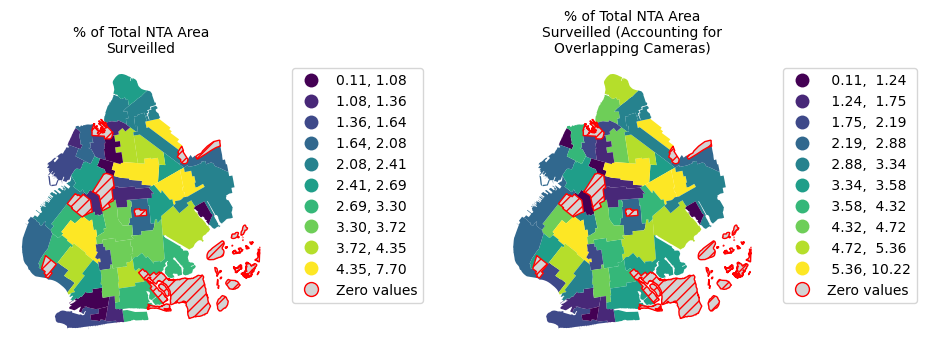

In [48]:
fig,ax = plt.subplots(1,2,figsize = (10,10))
nta_agg.plot(column='Proportion NTA Surveilled (Cum)', ax=ax[0], k=10, scheme='Quantiles', legend=True, 
              missing_kwds={"color": "lightgrey", "edgecolor": "red", "hatch": "///", "label": "Zero values"},
              legend_kwds={'bbox_to_anchor': (1.05, 1), 'loc': 'upper left'})
ax[0].set_title('% of Total NTA Area\nSurveilled', fontdict={'fontsize': 10, 'multialignment': 'center'})
nta_agg.plot(column='Proportion NTA Surveilled (Cum & Mult)', ax=ax[1], k=10, scheme='Quantiles', legend=True, 
              missing_kwds={"color": "lightgrey", "edgecolor": "red", "hatch": "///", "label": "Zero values"},
              legend_kwds={'bbox_to_anchor': (1.05, 1), 'loc': 'upper left'})
ax[1].set_title('% of Total NTA Area\nSurveilled (Accounting for\nOverlapping Cameras)', 
                 fontdict={'fontsize': 10, 'multialignment': 'center'})
fig.tight_layout()
ax[0].axis('off')
ax[1].axis('off')
plt.savefig('../Outputs/NTA_BK_CameraBuffer_200m_aggregates.png')

### notes for liz from 04/11 team meeting:

* include street area in denominator not NTA/Tract/Block area..

* Documentation while we do analysis

* color blind accessibility

* can we create a reverse buffer on the BBL shape file to account for surveilling private property